In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops


#from cnn_utils import *

%matplotlib inline
np.random.seed(1)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
classes = 2
X_train = np.expand_dims(np.load('X_train.npy'), axis = 3)
y_train = np.load('y_train.npy').flatten()
X_val = np.expand_dims(np.load('X_dev.npy'), axis = 3)
y_val = np.load('y_dev.npy').flatten()
X_test = np.expand_dims(np.load('X_test.npy'), axis = 3)
y_test = np.load('y_test.npy').flatten()


# construct 1-hot vector
Y_test = np.zeros((y_test.shape[0], 2)) # 2 classes 
Y_test[np.arange(y_test.shape[0]), y_test] = 1

Y_val = np.zeros((y_val.shape[0], 2)) # 2 classes 
Y_val[np.arange(y_val.shape[0]), y_val] = 1

Y_train = np.zeros((y_train.shape[0], 2)) # 2 classes 
Y_train[np.arange(y_train.shape[0]), y_train] = 1

print('Y_test shape is: ', Y_test.shape)
print('y_test: ', y_test[:10])
print('Y_test: ', Y_test[:10])

Y_test shape is:  (5036, 2)
y_test:  [1 1 0 1 0 1 1 0 1 0]
Y_test:  [[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [3]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 23496
number of test examples = 5036
X_train shape: (23496, 205, 110, 1)
Y_train shape: (23496, 2)
X_test shape: (5036, 205, 110, 1)
Y_test shape: (5036, 2)


In [4]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y

In [5]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1", [5, 5, 1, 32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [5, 5, 32, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

In [7]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,...]
    shuffled_Y = Y[permutation,...]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size, ...]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:(k + 1) * mini_batch_size, ...]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size: , ...]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:, ...]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [8]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    # FLATTEN
    P = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P, 2, activation_fn=None)

    return Z3

In [9]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost

In [18]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.001,
          num_epochs=10, minibatch_size=64, print_cost=True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape   
    n_y = Y_train.shape[1] 
    print('n_y is: ', Y_train.shape[1])
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # Start the session to compute the tensorflow graph
    with tf.Session(config = config) as sess:
        with tf.device("/gpu:0") as dev:
        
            # Run the initialization
            sess.run(init)

            # Do the training loop
            for epoch in range(num_epochs):

                minibatch_cost = 0.
                num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
                seed = seed + 1
                minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

                for minibatch in minibatches:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch
                    # IMPORTANT: The line that runs the graph on a minibatch.
                    # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                    _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})

                    minibatch_cost += temp_cost / num_minibatches


                # Print the cost every epoch
                if print_cost == True and epoch % 1 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                if print_cost == True and epoch % 1 == 0:
                    costs.append(minibatch_cost)


            # plot the cost
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()

            # Calculate the correct predictions
            predict_op = tf.argmax(Z3, 1)
            correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

            # Calculate accuracy on the test set
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            print(accuracy)
            train_accuracy = 0.
            test_accuracy = 0.


            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for index, minibatch in enumerate(minibatches):

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                cur_train_accuracy = accuracy.eval({X: minibatch_X, Y: minibatch_Y})
                train_accuracy = (train_accuracy * (index) + cur_train_accuracy) / (index + 1)
            minibatches = random_mini_batches(X_test, Y_test, minibatch_size, seed) 
            for index, minibatch in enumerate(minibatches):

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                cur_test_accuracy = accuracy.eval({X: minibatch_X, Y: minibatch_Y})
                test_accuracy = (test_accuracy * (index) + cur_test_accuracy) / (index + 1)
            

#             train_accuracy = accuracy.eval({X: X_train[:10,...], Y: Y_train[:10,...]})
#             test_accuracy = accuracy.eval({X: X_test[:10, ...], Y: Y_test[:10, ...]})
            print("Train Accuracy:", train_accuracy)
            print("Test Accuracy:", test_accuracy)

            return train_accuracy, test_accuracy, parameters

n_y is:  2
Cost after epoch 0: 0.279946
Cost after epoch 1: 0.085120
Cost after epoch 2: 0.046462
Cost after epoch 3: 0.037953
Cost after epoch 4: 0.016398
Cost after epoch 5: 0.021024
Cost after epoch 6: 0.030469
Cost after epoch 7: 0.003062
Cost after epoch 8: 0.001416
Cost after epoch 9: 0.000980


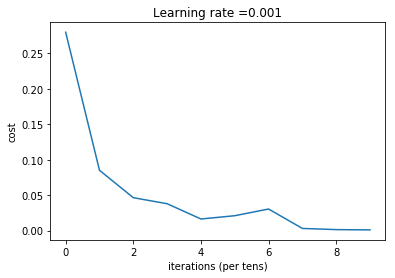

Tensor("Mean_1:0", shape=(), dtype=float32, device=/device:GPU:0)
Train Accuracy: 1.0
Test Accuracy: 1.0


In [19]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)
